In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("NCRB_CII_2023_Table_2A.1_0.csv")

df.columns = df.columns.str.strip().str.replace(" ", "_").str.replace(".", "").str.lower()

df = df.replace(["-", "NA", "N/A", "na", ""], np.nan)

for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        pass

missing_percent = df.isnull().sum() * 100 / len(df)

df = df.dropna(axis=1, thresh=len(df)*0.6)

for col in df.select_dtypes(include=np.number).columns:
    df[col] = df[col].fillna(df[col].median())

df = df.drop_duplicates()

df.reset_index(drop=True, inplace=True)

df.head()

,sl_no,state/ut,2021,2022,2023,mid-year_projected_population_(in_lakhs)_(2023),rate_of_murder_(2023),chargesheeting_rate_(2023)
0,1,Andhra Pradesh,956,925,922,532.2,1.7,91.7
1,2,Arunachal Pradesh,49,56,57,15.7,3.6,84.2
2,3,Assam,1192,1072,1025,358.2,2.9,67.2
3,4,Bihar,2799,2930,2862,1273.7,2.2,92.6
4,5,Chhattisgarh,1007,1013,958,302.9,3.2,94.1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 8 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   sl_no                                            39 non-null     object 
 1   state/ut                                         39 non-null     object 
 2   2021                                             39 non-null     int64  
 3   2022                                             39 non-null     int64  
 4   2023                                             39 non-null     int64  
 5   mid-year_projected_population_(in_lakhs)_(2023)  39 non-null     float64
 6   rate_of_murder_(2023)                            39 non-null     float64
 7   chargesheeting_rate_(2023)                       39 non-null     float64
dtypes: float64(3), int64(3), object(2)
memory usage: 2.6+ KB


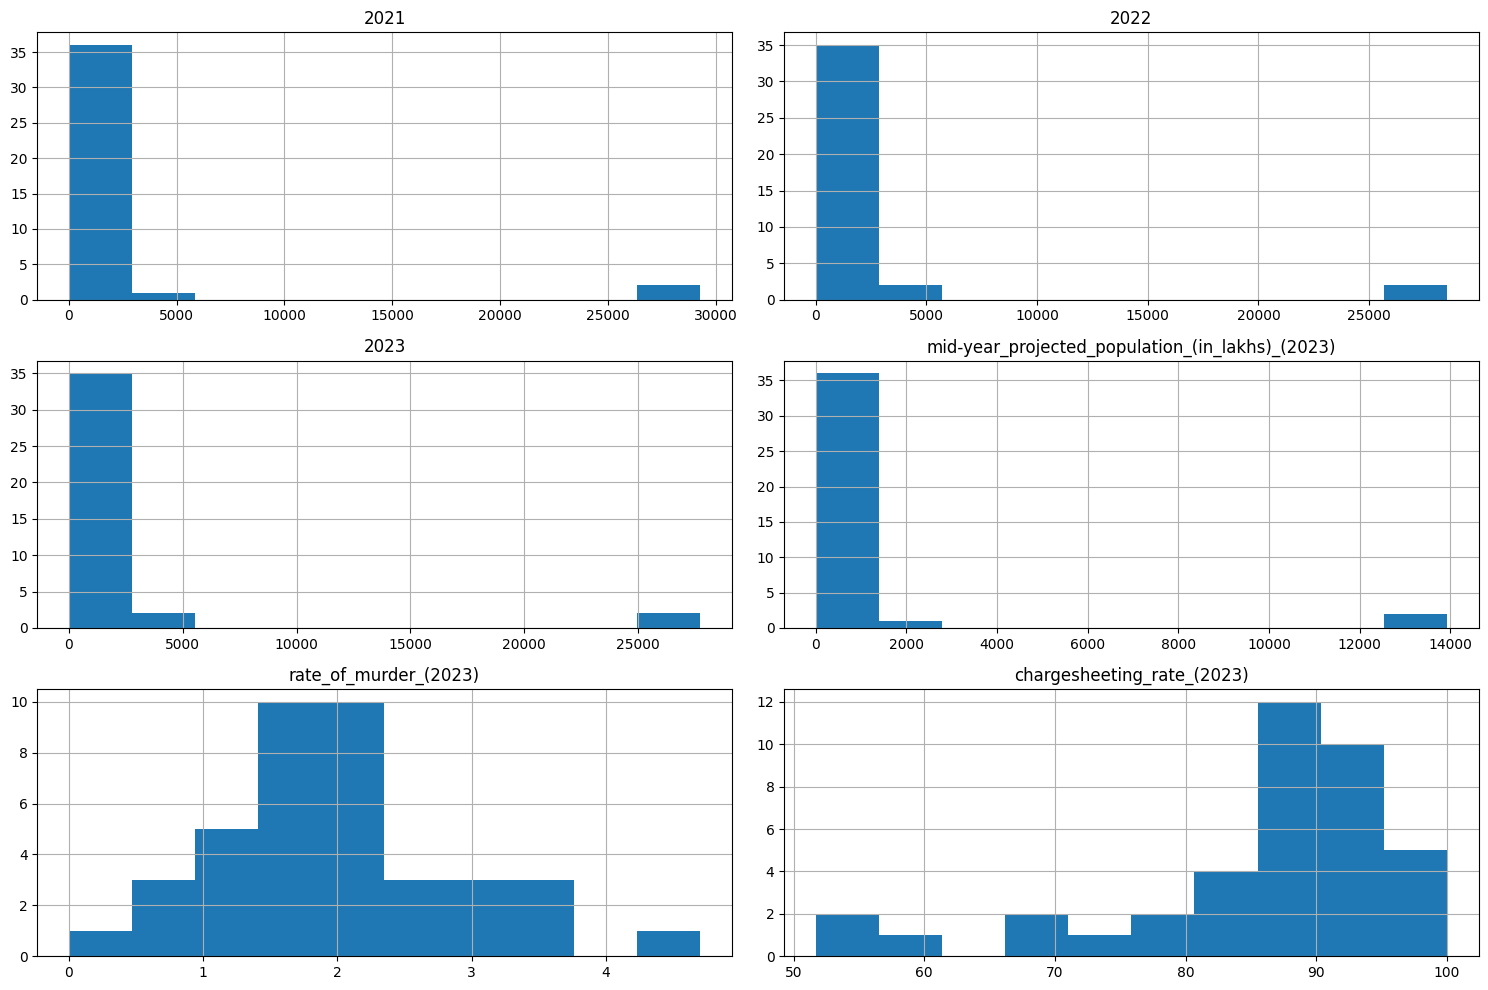

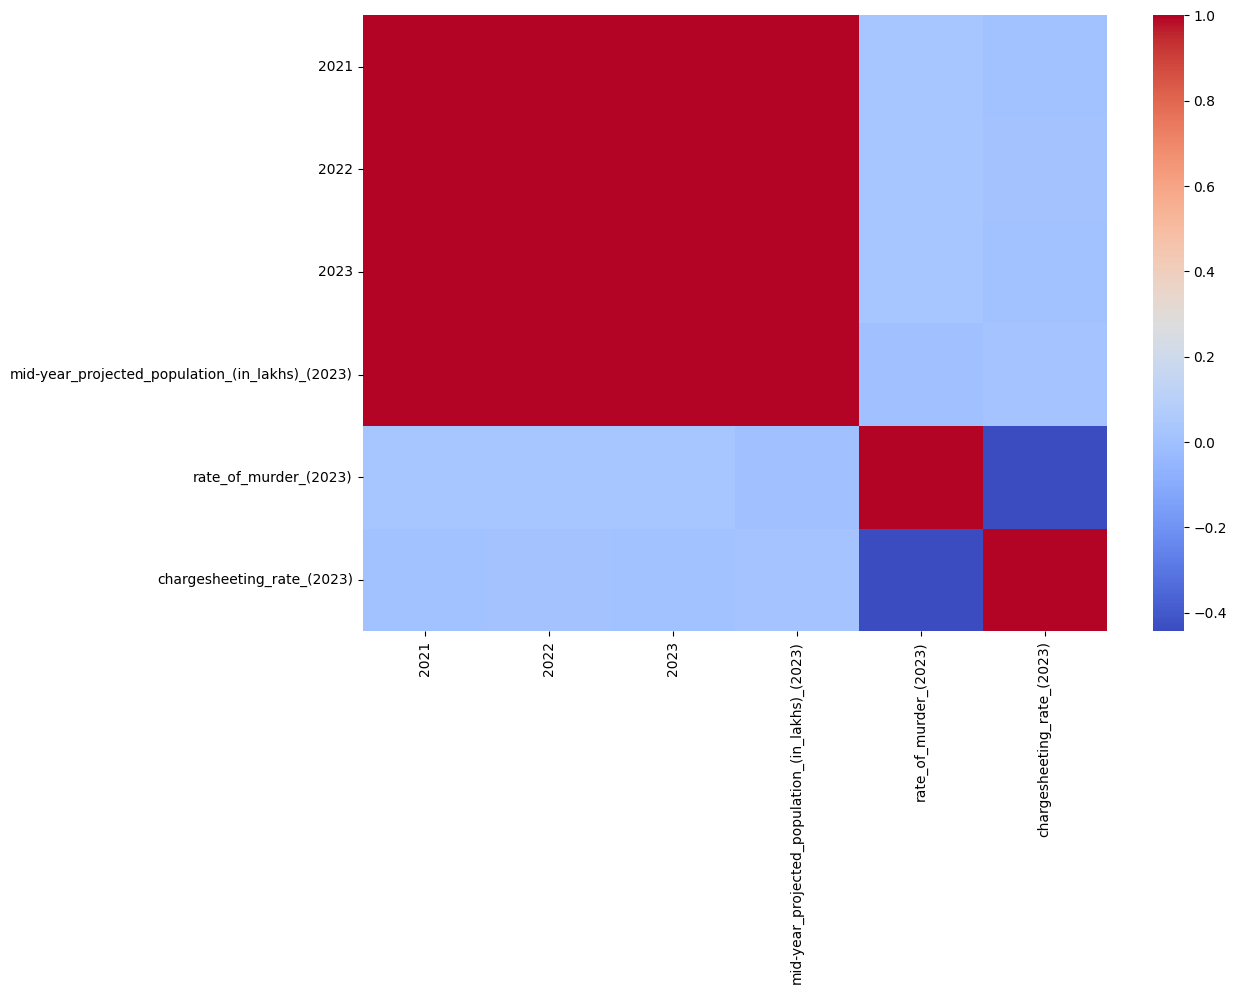

In [2]:
df.info()

df.describe()

import matplotlib.pyplot as plt

df.select_dtypes(include=np.number).hist(figsize=(15,10))
plt.tight_layout()
plt.show()

import seaborn as sns

plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap="coolwarm")
plt.show()

In [3]:
redundant_cols = []
df = df.drop(columns=redundant_cols, errors="ignore")

In [5]:
import pandas as pd
import numpy as np

df = pd.read_csv("NCRB_CII_2023_Table_2A.1_0.csv")

df.columns = df.columns.str.strip()

target = "Rate of Murder (2023)"

for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        pass

numeric_df = df.select_dtypes(include=np.number)

corr_target = numeric_df.corr()[target].abs()

low_corr_cols = corr_target[corr_target < 0.4].index
low_corr_cols = low_corr_cols.drop(target, errors="ignore")

df_step1 = df.drop(columns=low_corr_cols)

numeric_step1 = df_step1.select_dtypes(include=np.number)

corr_matrix = numeric_step1.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr_cols = [column for column in upper.columns if any(upper[column] > 0.9)]

df_reduced = df_step1.drop(columns=high_corr_cols)

print("Columns removed (low correlation <0.4):")
print(list(low_corr_cols))

print("\nColumns removed (high correlation >0.9):")
print(high_corr_cols)

print("\nFinal dataset shape:")
print(df_reduced.shape)

Columns removed (low correlation <0.4):
['2021', '2022', '2023', 'Mid-Year Projected Population (in Lakhs) (2023)']

Columns removed (high correlation >0.9):
[]

Final dataset shape:
(39, 4)


In [7]:
df_reduced.head()

,Sl. No.,State/UT,Rate of Murder (2023),Chargesheeting Rate (2023)
0,1,Andhra Pradesh,1.7,91.7
1,2,Arunachal Pradesh,3.6,84.2
2,3,Assam,2.9,67.2
3,4,Bihar,2.2,92.6
4,5,Chhattisgarh,3.2,94.1


In [8]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler

target = "Rate of Murder (2023)"

X = df_reduced.drop(columns=[target])
y = df_reduced[target]

X_numeric = X.select_dtypes(include="number")

selector = SelectKBest(score_func=f_regression, k=5)
X_selected = selector.fit_transform(X_numeric, y)

selected_features = X_numeric.columns[selector.get_support()]

print("Top Selected Features:")
print(selected_features)

Top Selected Features:
Index(['Chargesheeting Rate (2023)'], dtype='object')


C:\Users\prath\AppData\Roaming\Python\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=5 is greater than n_features=1. All the features will be returned.
  warnings.warn(


In [9]:
feature_scores = pd.DataFrame({
    "Feature": X_numeric.columns,
    "Score": selector.scores_
}).sort_values(by="Score", ascending=False)

print(feature_scores)

                      Feature     Score
0  Chargesheeting Rate (2023)  9.061222


In [10]:
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print("Original Shape:", X_scaled.shape)
print("Reduced Shape after PCA:", X_pca.shape)

Original Shape: (39, 1)
Reduced Shape after PCA: (39, 1)


In [11]:
print("Explained Variance Ratio:")
print(pca.explained_variance_ratio_)

print("Total Variance Retained:")
print(sum(pca.explained_variance_ratio_))

Explained Variance Ratio:
[1.]
Total Variance Retained:
1.0


In [12]:
print("Number of numeric features used in PCA:")
print(X_numeric.shape[1])

print("Columns used:")
print(list(X_numeric.columns))

Number of numeric features used in PCA:
1
Columns used:
['Chargesheeting Rate (2023)']


In [13]:
top_features = corr_target.sort_values(ascending=False)[1:8].index
df_model = df[top_features.tolist() + [target]]

In [14]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler

target = "Rate of Murder (2023)"

X = df_model.drop(columns=[target])
y = df_model[target]

X_numeric = X.select_dtypes(include="number")

selector = SelectKBest(score_func=f_regression, k=5)
X_selected = selector.fit_transform(X_numeric, y)

selected_features = X_numeric.columns[selector.get_support()]

print("Top Selected Features:")
print(selected_features)

Top Selected Features:
Index(['Chargesheeting Rate (2023)', '2023', '2022', '2021',
       'Mid-Year Projected Population (in Lakhs) (2023)'],
      dtype='object')


In [15]:
feature_scores = pd.DataFrame({
    "Feature": X_numeric.columns,
    "Score": selector.scores_
}).sort_values(by="Score", ascending=False)

print(feature_scores)

                                           Feature     Score
0                       Chargesheeting Rate (2023)  9.061222
1                                             2023  0.031163
2                                             2022  0.027470
3                                             2021  0.026097
4  Mid-Year Projected Population (in Lakhs) (2023)  0.000125


In [16]:
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print("Original Shape:", X_scaled.shape)
print("Reduced Shape after PCA:", X_pca.shape)

Original Shape: (39, 5)
Reduced Shape after PCA: (39, 2)


In [17]:
print("Explained Variance Ratio:")
print(pca.explained_variance_ratio_)

print("Total Variance Retained:")
print(sum(pca.explained_variance_ratio_))

Explained Variance Ratio:
[0.79960093 0.19998508]
Total Variance Retained:
0.9995860113675115


In [18]:
pca_components = pd.DataFrame(
    pca.components_,
    columns=X_numeric.columns,
    index=["PC1", "PC2"]
)

print(pca_components)

     Chargesheeting Rate (2023)      2023      2022      2021  \
PC1                    0.006202  0.500048  0.500075  0.500085   
PC2                    0.999960 -0.005220 -0.004047 -0.005485   

     Mid-Year Projected Population (in Lakhs) (2023)  
PC1                                         0.499753  
PC2                                         0.002352  


In [19]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

target = "Rate of Murder (2023)"

X = df_model.drop(columns=[target])
y = df_model[target]

state_column = df["State/UT"] if "State/UT" in df.columns else None

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df[target] = y.values

if state_column is not None:
    pca_df["State/UT"] = state_column.values

print(pca.explained_variance_ratio_)

[0.79960093 0.19998508]


In [20]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

pca_df["Cluster"] = clusters

pca_df.head()

,PC1,PC2,Rate of Murder (2023),State/UT,Cluster
0,-0.396377,0.545159,1.7,Andhra Pradesh,1
1,-0.703552,-0.110236,3.6,Arunachal Pradesh,1
2,-0.399315,-1.601959,2.9,Assam,0
3,0.203318,0.619949,2.2,Bihar,1
4,-0.419213,0.755121,3.2,Chhattisgarh,1


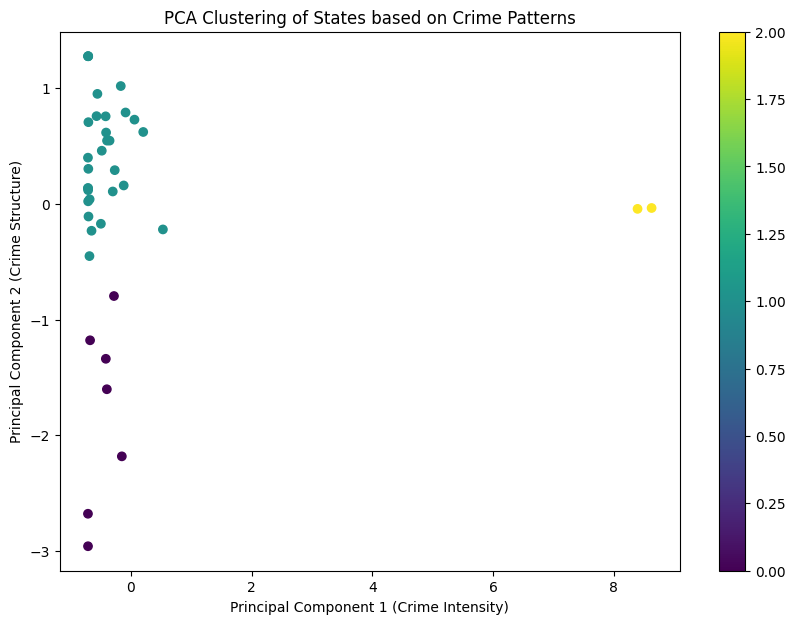

In [21]:
plt.figure(figsize=(10,7))

scatter = plt.scatter(
    pca_df["PC1"],
    pca_df["PC2"],
    c=pca_df["Cluster"]
)

plt.xlabel("Principal Component 1 (Crime Intensity)")
plt.ylabel("Principal Component 2 (Crime Structure)")
plt.title("PCA Clustering of States based on Crime Patterns")
plt.colorbar(scatter)
plt.show()

In [22]:
cluster_analysis = pca_df.groupby("Cluster")[target].mean().sort_values(ascending=False)

print("Average Murder Rate by Cluster:")
print(cluster_analysis)

high_risk_cluster = cluster_analysis.index[0]

high_risk_states = pca_df[pca_df["Cluster"] == high_risk_cluster]

print("\nHigh-Risk States:")
print(high_risk_states[["State/UT", target]])

Average Murder Rate by Cluster:
Cluster
0    2.757143
2    2.000000
1    1.806667
Name: Rate of Murder (2023), dtype: float64

High-Risk States:
             State/UT  Rate of Murder (2023)
2               Assam                    2.9
7             Haryana                    3.4
9           Jharkhand                    3.7
14            Manipur                    4.7
15          Meghalaya                    1.8
20          Rajasthan                    2.2
33  Jammu and Kashmir                    0.6


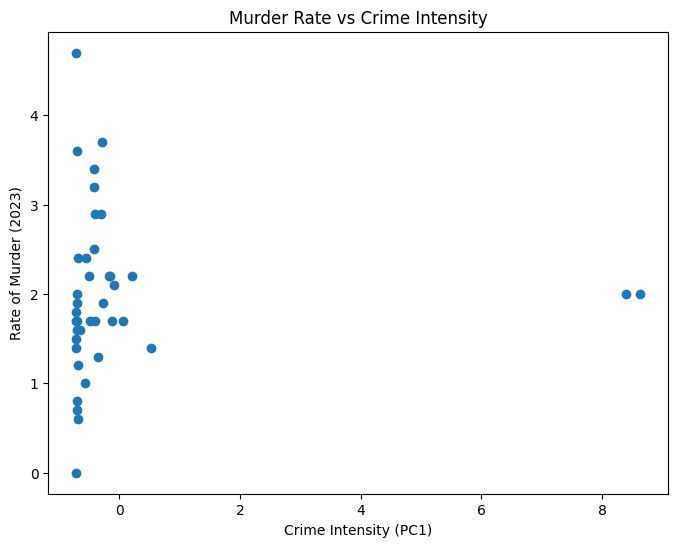

In [ ]:
plt.figure(figsize=(8,6))
colors = np.arange(len(pca_df))

plt.scatter(pca_df["PC1"], pca_df[target],c=colors,cmap="plasma")

plt.xlabel("Crime Intensity (PC1)")
plt.ylabel("Rate of Murder (2023)")
plt.title("Murder Rate vs Crime Intensity")

plt.show()

In [24]:
corr_value = np.corrcoef(pca_df["PC1"], pca_df[target])[0,1]

print("Correlation between Crime Intensity and Murder Rate:")
print(corr_value)

Correlation between Crime Intensity and Murder Rate:
0.019790489187032346
